In [1]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

In [2]:
from models.backbone import Backbone, EmbeddingNetwork
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor, Generator_loss
from models.unet import UNet

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
H = 30
W= 30

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform2 = T.Compose([
T.Resize((H,W)),
T.ToTensor()
])

In [5]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

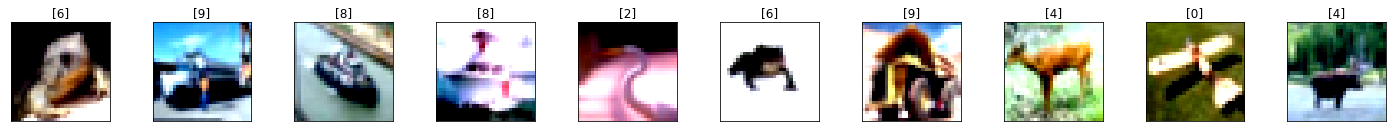

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [8]:
backbone  = EmbeddingNetwork()
encoder = EncoderModule(d_model=256,num_encoder_layers=6)#.to(device)
model = Joiner(backbone, encoder, bypass=False, hidden_dim=256, batch_size=10, image_h=H, image_w=W,penalty_factor="2")

In [9]:
model = model.to(device)

In [10]:
#TESTING MODEL ON A SINGLE IMAGE

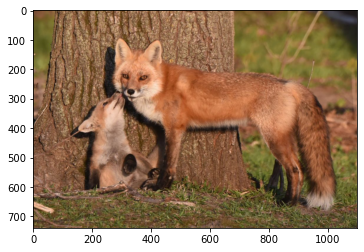

In [11]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)
plt.plot()
plt.imshow(im)

In [12]:
img = transform2(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 30, 30])


In [13]:
outputs, sattn, pattn = model(img.to(device))

In [14]:
print("Output shape:", outputs.shape)
#print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
#print("Encoder output shape:", att.shape)
#print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])
Attention Maps shape: torch.Size([1, 30, 30, 30, 30])


In [15]:
#Training Model

In [16]:
#def add_noise(inputs):
#    noise = torch.randn_like(inputs)*0.2
#    return inputs + noise

In [17]:
add_noise = UNet(3,3,bilinear=False)
add_noise = add_noise.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

In [19]:
gen_criterion = Generator_loss(beta=0.0000001, gamma=0.01,sigma=1)
gen_optimizer = torch.optim.Adam(add_noise.parameters(), lr = 0.0001)
gen_lr_scheduler = lr_scheduler.StepLR(gen_optimizer, step_size=6, gamma=0.1)

In [ ]:
epochs = 24
running_loss_history = [] # training loss - to generate a plot
running_gen_loss_history = []
running_corrects_history = [] # traning accuracy
running_noised_corrects_history = [] # traning accuracy
val_running_loss_history = [] # validation loss
val_running_corrects_history = [] # validation accuracy
val_running_noised_loss_history = [] # validation loss
val_running_noised_corrects_history = [] # validation accuracy

for e in range(epochs):
  
    start_time = time.time()
    print('-' * 10)
    print('Epoch {}/{}'.format(e+1, epochs))
    print('-' * 10)
    
    best_model_wts = model.state_dict()
    best_val_acc = 0
    
    running_loss = 0.0
    running_gen_loss = 0.0
    running_corrects = 0.0
    running_noised_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    val_noised_running_loss = 0.0
    val_noised_running_corrects = 0.0

    for inputs, labels in training_loader:
        
        #TRAINING THE MODEL
        
        inputs = inputs.to(device) # allow gpu use
        labels = labels.to(device) # allow gpu use
        outputs, _, _ = model(inputs) #gives the output of the last layer
        real_loss = criterion(outputs, labels) # comparing outputs and labels using the criteria
        
        noised_inputs = add_noise(inputs) # allow gpu use
        noised_outputs, _, _ = model(noised_inputs) #gives the output of the last layer
        noised_loss = criterion(noised_outputs, labels) # comparing outputs and labels using the criteria

        loss = real_loss + noised_loss
        
        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
        optimizer.step() #optimize weights 

        _, preds = torch.max(outputs, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
        _, noise_preds = torch.max(noised_outputs, 1)
        running_loss += loss.item() # the sum of the loss of all itens
        running_corrects += torch.sum(preds == labels.data) # the sum of correct prediction on an epochs
        running_noised_corrects += torch.sum(noise_preds == labels.data) # the sum of correct prediction on an epochs
        
        Typenone = 0
        zeros = 0
        normal = 0
        for name, param in model.named_parameters():
            if param.grad == None:
                Typenone +=1
            elif torch.sum(param.grad) == 0:
                zeros += 1
            else:
                normal += 1
        if Typenone >10:
            print("None parameters:",Typenone)
            for name, param in model.named_parameters():
                if param.grad == None:
                    print(name)
        if zeros > 5:
            print("Zero Grad Parameters:", zeros)
        
        
        #TRAINING THE GENERATOR
        
        noised_inputs = add_noise(inputs)
        noised_outputs, _, noised_pattn = model(noised_inputs)
        model_loss = criterion(noised_outputs, labels)
        gen_loss = gen_criterion(noised_pattn, noised_inputs, inputs, model_loss)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        running_gen_loss += gen_loss.item()
                
    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                noised_val_inputs = add_noise(val_inputs) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_outputs, _, _ = model(val_inputs) #passes the image through the network and get the output
                val_loss = criterion(val_outputs, val_labels) #compare output and labels to get the loss 

                _, val_preds = torch.max(val_outputs, 1) #same as for training
                val_running_loss += val_loss.item() #same as for training
                val_running_corrects += torch.sum(val_preds == val_labels.data) #same as for training
                
                val_noised_outputs, _, _ = model(noised_val_inputs) #passes the image through the network and get the output
                val_noised_loss = criterion(val_noised_outputs, val_labels) #compare output and labels to get the loss 

                _, val_noised_preds = torch.max(val_noised_outputs, 1) #same as for training
                val_noised_running_loss += val_noised_loss.item() #same as for training
                val_noised_running_corrects += torch.sum(val_noised_preds == val_labels.data) #same as for training

                
    model_lr_scheduler.step()
    gen_lr_scheduler.step()
    
    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(training_dataset) # the sum of the loss of all itens divided by the number of itens
    gen_epoch_loss = running_gen_loss/len(training_dataset)
    epoch_acc = running_corrects.float()/ len(training_dataset) # the sum of correct predictions divided by the number of itens
    epoch_noised_acc = running_noised_corrects.float()/ len(training_dataset)
    running_loss_history.append(epoch_loss) #append to respective list
    running_gen_loss_history.append(gen_epoch_loss)
    running_corrects_history.append(epoch_acc) #append to respective list
    running_noised_corrects_history.append(epoch_noised_acc) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(validation_dataset)
    val_noised_epoch_loss = val_noised_running_loss/len(validation_dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_dataset)
    val_noised_epoch_acc = val_noised_running_corrects.float()/ len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    val_running_corrects_history.append(val_epoch_acc) #append to respective list
    val_running_noised_loss_history.append(val_noised_epoch_loss) #append to respective list
    val_running_noised_corrects_history.append(val_noised_epoch_acc) #append to respective list
    epoch_time_elapsed = time.time() - start_time
    
    if val_epoch_acc > best_val_acc:
        best_model_wts = model.state_dict()
    
    print('Epoch training complete in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))
    print('training loss: {:.4f}, acc {:.4f}, noised acc {:.4f} '.format(epoch_loss, epoch_acc.item(), epoch_noised_acc.item()))
    print('Generator loss: {:.4f}'.format(gen_epoch_loss))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    print('validation noised loss: {:.4f}, validation noised acc {:.4f} '.format(val_noised_epoch_loss, val_noised_epoch_acc.item()))

----------
Epoch 1/24
----------
Epoch training complete in 37m 1s
training loss: 0.3933, acc 0.3862, noised acc 0.3866 
Generator loss: -0.0003
validation loss: 0.1398, validation acc 0.5035 
validation noised loss: 0.1406, validation noised acc 0.5041 
----------
Epoch 2/24
----------
Epoch training complete in 36m 30s
training loss: 0.2834, acc 0.5130, noised acc 0.5066 
Generator loss: 0.0001
validation loss: 0.1374, validation acc 0.5245 
validation noised loss: 0.1406, validation noised acc 0.5170 
----------
Epoch 3/24
----------
Epoch training complete in 36m 11s
training loss: 0.2439, acc 0.5804, noised acc 0.5654 
Generator loss: 0.0005
validation loss: 0.1184, validation acc 0.5835 
validation noised loss: 0.1195, validation noised acc 0.5817 
----------
Epoch 4/24
----------
Epoch training complete in 36m 11s
training loss: 0.2170, acc 0.6248, noised acc 0.6100 
Generator loss: 0.0008
validation loss: 0.1106, validation acc 0.6118 
validation noised loss: 0.1156, validation

In [ ]:
cifar_img = training_dataset[123][0].unsqueeze(0)
cifar_img = cifar_img.to(device)
cifar_noised = add_noise(cifar_img)
outputs2, sattn2, pattn2 = model(cifar_img)
sattn2 = sattn2.reshape(1,30,30,30,30)
outputs_noised, sattn_noised, pattn_noised = model(cifar_noised)
sattn_noised = sattn_noised.reshape(1,30,30,30,30)
msloss = nn.MSELoss()
print("Penalized self attention:",torch.sum(pattn2)*0.0000001)
print("L2 Recreation loss",msloss(cifar_noised[0],cifar_img[0])*1)

In [ ]:
pix_h = 0
pix_w = 29
threshold = torch.sum(sattn2[0,pix_h,pix_w,...])/180#6.3665e-38
threshold_noised = torch.sum(sattn_noised[0,pix_h,pix_w,...])/150#6.3665e-38
plt.subplot(221)
plt.imshow(cifar_img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(cifar_noised[0].cpu().detach().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn2[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest',vmax=threshold)
plt.subplot(224)
plt.imshow(sattn_noised[0,pix_h,pix_w,...].cpu().detach().numpy(),vmax=threshold_noised)
#plt.subplot(222)
#plt.imshow((cifar_img[0]-cifar_noised[0]).cpu().detach().permute(1, 2, 0))

In [ ]:
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(),'test/Generator_Encoder_no_bypass_CIFAR10_4.pth')

In [ ]:
msloss = nn.MSELoss()
print(torch.sum(pattn2))
print(msloss(cifar_noised[0],cifar_img[0]))

In [ ]:
outputs, sattn, pattn = model(img.to(device))

In [ ]:
pix_h = 29
pix_w = 29
threshold = torch.sum(sattn[0,pix_h,pix_w,...])/180#6.3665e-38
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest',vmax=threshold)